<a href="https://colab.research.google.com/github/ghost08A/model-pra/blob/main/pra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import ฟังก์ชั่นที่ต้องใช้ทั้งหมด**

In [1]:
from google.colab import drive
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ConvNeXtTiny
import joblib

### **แตกไฟล์ข้อมูล**

In [2]:
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/fetsh_v2.zip -d /content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open /content/drive/MyDrive/fetsh_v2.zip, /content/drive/MyDrive/fetsh_v2.zip.zip or /content/drive/MyDrive/fetsh_v2.zip.ZIP.


### **ทดสอบดูไฟล์รูป**

(<Axes: >, <matplotlib.image.AxesImage at 0x7a5491ad0390>)

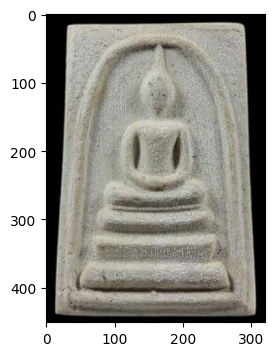

In [3]:
img1 = cv2.imread('/content/fetsh_v2/images_train/Train_0.png')
img1 = cv2.cvtColor(img1 , cv2.COLOR_BGR2RGB)


plt.figure(figsize=(8,4))
plt.subplot(121),plt.imshow(img1)

In [4]:
df_test = pd.read_csv("/content/fetsh_v2/test.csv")
df_train = pd.read_csv('/content/trainset1.csv')
print(df_test.head())

     filename          label_pra       label_wat   label_pim  label_year  \
0  Test_0.png  พระสมเด็จวัดระฆัง        วัดระฆัง   พิมพ์ใหญ่        2523   
1  Test_1.png  พระสมเด็จวัดระฆัง        วัดระฆัง    พิมพ์แซม        2520   
2  Test_2.png   พระสมเด็จเกศไชโย  วัดไชโยวรวิหาร  พิมพ์7ชั้น        2523   
3  Test_3.png  พระสมเด็จวัดระฆัง        วัดระฆัง   พิมพ์ใหญ่        2523   
4  Test_4.png  พระสมเด็จวัดระฆัง        วัดระฆัง   พิมพ์ใหญ่        2523   

                 name  
0          หลวงปู่นาค  
1          หลวงปู่หิน  
2  สมเด็จพระพุฒาจารย์  
3          หลวงปู่นาค  
4          หลวงปู่นาค  


## **ตรวจสอบว่ามีข้อมูลเฉพาะอะไรบ้าง**

In [24]:
df_train.loc[df_train['label_year'] == '2520.0', 'label_year'] = '2520'

In [16]:
df_test['label_year'] = df_test['label_year'].astype(str)


In [17]:
print("Label Pra:", df_train['label_pra'].unique())
print("Label Wat:", df_train['label_wat'].unique())
print("Label Pim:", df_train['label_pim'].unique())
print("Label Year:", df_train['label_year'].unique())
print("Label Name:", df_train['name'].unique())

Label Pra: ['พระสมเด็จวัดระฆัง' 'พระสมเด็จเกศไชโย' 'พระรอด' 'พระนางพญา'
 'เหรียญหลวงปู่ทวด' 'พระกริ่งปวเรศ' 'not_pra']
Label Wat: ['วัดระฆัง' 'วัดไชโยวรวิหาร' 'วัดมหาวัน' 'วัดนางพญา' 'วัดช้างให้'
 'วัดบวรนิเวศวิหาร' 'not_pra']
Label Pim: ['พิมพ์ใหญ่' 'พิมพ์แซม' 'พิมพ์7ชั้น' 'พิมพ์เข่าโค้ง' 'พิมพ์เสมาเล็ก'
 'พิมพ์สมบูรณ์พูนสุข' 'not_pra']
Label Year: ['2523' '2520' '1200' '2090' '2500' '2434' 'not_pra']
Label Name: ['หลวงปู่นาค' 'หลวงปู่หิน' 'สมเด็จพระพุฒาจารย์' 'พระนางจามเทวี'
 'พระวิสุทธิกษัตริย์ธิดา' 'พระครูวิสัยโสภณ' 'สมเด็จพระมหาสมณเจ้า'
 'not_pra']


In [18]:
print("Label Pra:", df_test['label_pra'].unique())
print("Label Wat:", df_test['label_wat'].unique())
print("Label Pim:", df_test['label_pim'].unique())
print("Label Year:", df_test['label_year'].unique())
print("Label Name:", df_test['name'].unique())

Label Pra: ['พระสมเด็จวัดระฆัง' 'พระสมเด็จเกศไชโย' 'พระรอด' 'พระนางพญา'
 'เหรียญหลวงปู่ทวด' 'พระกริ่งปวเรศ']
Label Wat: ['วัดระฆัง' 'วัดไชโยวรวิหาร' 'วัดมหาวัน' 'วัดนางพญา' 'วัดช้างให้'
 'วัดบวรนิเวศวิหาร']
Label Pim: ['พิมพ์ใหญ่' 'พิมพ์แซม' 'พิมพ์7ชั้น' 'พิมพ์เข่าโค้ง' 'พิมพ์เสมาเล็ก'
 'พิมพ์สมบูรณ์พูนสุข']
Label Year: ['2523' '2520' '1200' '2090' '2500' '2434']
Label Name: ['หลวงปู่นาค' 'หลวงปู่หิน' 'สมเด็จพระพุฒาจารย์' 'พระนางจามเทวี'
 'พระวิสุทธิกษัตริย์ธิดา' 'พระครูวิสัยโสภณ' 'สมเด็จพระมหาสมณเจ้า']


In [32]:
df_test.to_csv('/content/test.csv', index=False)

### **แปลงข้อมูลให้อยู่ในรูปแบบ 0 1 2**

In [7]:
encoders = {} #สร้างdictที่เก็บ encoders แต่ละ label
for col in ['label_pra', 'label_wat', 'label_pim', 'label_year', 'name']: #วนลูปแต่ละ column
    le = LabelEncoder()  #สร้างตัวแปร le เก็บฟังก์ชั่น LabelEncoder()
    df_train[col + '_enc'] = le.fit_transform(df_train[col]) #ใช้ .fit_transfrom แต่ละ column ให้แปลงเป็น 0 1 เก็บในชื่อใหม่+ enc
    encoders[col] = le #encoders เก็บข้อมูลที่แปลง


In [ ]:
joblib.dump(encoders, 'encoders.pkl')

['encoders.pkl']

In [28]:
# ดูตัวอย่างข้อมูลหลังจากแปลง
print(df_train.head())
#print(encoders['label_pra'].inverse_transform([1]) )
print(encoders.keys())  # ดูว่ามีอะไรเก็บอยู่
print(encoders['label_pra'].classes_)  # ดูว่ารู้จัก label อะไรบ้าง

      filename          label_pra label_wat  label_pim label_year        name  \
0  Train_0.png  พระสมเด็จวัดระฆัง  วัดระฆัง  พิมพ์ใหญ่       2523  หลวงปู่นาค   
1  Train_1.png  พระสมเด็จวัดระฆัง  วัดระฆัง  พิมพ์ใหญ่       2523  หลวงปู่นาค   
2  Train_2.png  พระสมเด็จวัดระฆัง  วัดระฆัง  พิมพ์ใหญ่       2523  หลวงปู่นาค   
3  Train_3.png  พระสมเด็จวัดระฆัง  วัดระฆัง  พิมพ์ใหญ่       2523  หลวงปู่นาค   
4  Train_4.png  พระสมเด็จวัดระฆัง  วัดระฆัง  พิมพ์ใหญ่       2523  หลวงปู่นาค   

   label_pra_enc  label_wat_enc  label_pim_enc  label_year_enc  name_enc  
0              4              5              6               5         6  
1              4              5              6               5         6  
2              4              5              6               5         6  
3              4              5              6               5         6  
4              4              5              6               5         6  
dict_keys(['label_pra', 'label_wat', 'label_pim', 'label_year',

### เตรียมรูปภาพสำหรับ train

In [8]:
image_size = (128, 128) # กำหนดขนาดทุกรูป 128
X = [] #สร้าง list เก็บรูป
failed_images = [] #สร้าง list เก็บรูปที่อ่านไม่ได้
for filename in df_train['filename']: #วนลูปทุกรูปผ่าน column filename
    path = os.path.join("/content/fetsh_v2/images_train/", filename )  # เปลี่ยน path ตามจริง
    img = cv2.imread(path) #อ่านรูปเก็บใน img เป็น array ที่แทนค่ารูปภาพ
    if img is None: # ถ้าอ่านค่าไม่ได้ให้แจ้งเตือนและเก็บภาพไว้ใน failed_images
        print(f"❌ ไม่พบรูปภาพ: {path}")
        failed_images.append(filename)
        continue
    img = cv2.resize(img, image_size) #ย่อภาพให้เป็นขนาดที่กำหนด
    img = img / 255.0  # normalize ค่าพิกเซลให้เป็นช่วง [0.0, 1.0]
    X.append(img) #เพิ่มรูปใน X[]
    #print(img)

X = np.array(X) #แปลงภาพ list เป็น array เพราะโมเดลต้องใช้ array


In [30]:
print(X.shape)

(8073, 128, 128, 3)


### เตรียมข้อมูล Label หลายอัน (Multi-output labels) และแยก X_train X_test

In [9]:
y = [
    to_categorical(df_train['label_pra_enc']),
    to_categorical(df_train['label_wat_enc']),
    to_categorical(df_train['label_pim_enc']),
    to_categorical(df_train['label_year_enc']),
    to_categorical(df_train['name_enc']),
]#สร้าง list ที่เก็บlabel แต่ละประเภท


X_train, X_test, y_train, y_test = train_test_split(X, list(zip(*y)), test_size=0.2, random_state=42)#แยกtrain test
#zip(*y) คือรวม label ของรูปแต่ละรูป ให้เป็น 1 ชุด
#( y[0][0], y[1][0], y[2][0], y[3][0], y[4][0] )  ← label ของภาพที่ 0
#ต้อง zip เพราะ train_test_split() ต้องการแบบ 1 รูปต่อ 1 ชุดข้อมูล

y_train = [np.array(label) for label in zip(*y_train)]#แยก tuple กลับเป็น list ของแต่ละ label อีกครั้ง
y_test = [np.array(label) for label in zip(*y_test)]
#เพิ่มนำไปให้โมเดล

In [10]:
y_train = [y[0] if isinstance(y, tuple) else y for y in y_train]
print(type(y_train))
print(len(y_train))
for i, y in enumerate(y_train):
    print(f"y_train[{i}].shape: {y.shape}")

<class 'list'>
5
y_train[0].shape: (6458, 7)
y_train[1].shape: (6458, 7)
y_train[2].shape: (6458, 7)
y_train[3].shape: (6458, 7)
y_train[4].shape: (6458, 8)


### สร้าง Input Output ของโมเดล CNN และเทรนโมเดล CNN

In [11]:
 #CNN multi-output model
inputs = Input(shape=(128, 128, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

outputs = [
    Dense(y_train[0].shape[1], activation='softmax', name='label_pra')(x),
    Dense(y_train[1].shape[1], activation='softmax', name='label_wat')(x), #กำหนด output 5 เองให้เป็น multi output
    Dense(y_train[2].shape[1], activation='softmax', name='label_pim')(x),
    Dense(y_train[3].shape[1], activation='softmax', name='label_year')(x),
    Dense(y_train[4].shape[1], activation='softmax', name='label_name')(x)
]


model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=Adam(), #ปรับน้ำหนักอัตโนมัติ
    loss={
        'label_pra': 'categorical_crossentropy',
        'label_wat': 'categorical_crossentropy',
        'label_pim': 'categorical_crossentropy',
        'label_year': 'categorical_crossentropy',#ดู loss ของแต่ละ output แยกกัน
        'label_name': 'categorical_crossentropy',
    },
    metrics={
        'label_pra': 'accuracy',
        'label_wat': 'accuracy', #ดู accuracy ของแต่ละ output แยกกัน
        'label_pim': 'accuracy',
        'label_year': 'accuracy',
        'label_name': 'accuracy',
    }
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,                # หยุดถ้าไม่ดีขึ้นใน 6 รอบ
    restore_best_weights=True # เอาน้ำหนักตอนดีที่สุดกลับมาใช้
)

history = model.fit( X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop])


Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - label_name_accuracy: 0.5269 - label_name_loss: 1.3397 - label_pim_accuracy: 0.5197 - label_pim_loss: 1.2828 - label_pra_accuracy: 0.5611 - label_pra_loss: 1.2141 - label_wat_accuracy: 0.5556 - label_wat_loss: 1.2236 - label_year_accuracy: 0.5917 - label_year_loss: 1.1372 - loss: 6.1974 - val_label_name_accuracy: 0.8173 - val_label_name_loss: 0.5051 - val_label_pim_accuracy: 0.8050 - val_label_pim_loss: 0.5469 - val_label_pra_accuracy: 0.8560 - val_label_pra_loss: 0.4276 - val_label_wat_accuracy: 0.8591 - val_label_wat_loss: 0.4248 - val_label_year_accuracy: 0.8824 - val_label_year_loss: 0.3671 - val_loss: 2.2648
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - label_name_accuracy: 0.8482 - label_name_loss: 0.4226 - label_pim_accuracy: 0.8423 - label_pim_loss: 0.4373 - label_pra_accuracy: 0.8782 - label_pra_loss: 0.3546 - label_wat_accuracy: 0.8783 - label_wat_loss: 0.3540 - label_year_accuracy: 0.8885 - label_year_loss: 0.31

# สร้าง Input Output ของโมเดลและใช้โมเดลที่เคยเทรนไว้แล้วมาปรับกับโมเดลเรา  


In [23]:
base_model = MobileNetV2(weights='imagenet'
, include_top=False,#ส่งภาพเข้า base_model และใช้ GlobalAveragePooling2D ย่อให้เหลือ 1 vector
input_shape=(128, 128, 3))
# Freeze ก่อน
base_model.trainable = False


inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

#  output 5 อัน
output_pra = Dense(y_train[0].shape[1], activation='softmax', name='label_pra')(x)
output_wat = Dense(y_train[1].shape[1], activation='softmax', name='label_wat')(x)
output_pim = Dense(y_train[2].shape[1], activation='softmax', name='label_pim')(x)
output_year = Dense(y_train[3].shape[1], activation='softmax', name='label_year')(x)
output_name = Dense(y_train[4].shape[1], activation='softmax', name='label_name')(x)

model = Model(inputs=inputs, outputs=[output_pra, output_wat, output_pim, output_year, output_name])


model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss={
        'label_pra': 'categorical_crossentropy',
        'label_wat': 'categorical_crossentropy',
        'label_pim': 'categorical_crossentropy',
        'label_year': 'categorical_crossentropy',
        'label_name': 'categorical_crossentropy'
    },
    metrics={
        'label_pra': 'accuracy',
        'label_wat': 'accuracy',
        'label_pim': 'accuracy',
        'label_year': 'accuracy',
        'label_name': 'accuracy'
    }
)

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


base_model.trainable = True
for layer in base_model.layers[:-40]:  # ล็อกไว้ทุกชั้น ยกเว้น 40 ชั้นท้าย
    layer.trainable = False


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'label_pra': 'categorical_crossentropy',
        'label_wat': 'categorical_crossentropy',
        'label_pim': 'categorical_crossentropy',
        'label_year': 'categorical_crossentropy',
        'label_name': 'categorical_crossentropy'
    },
    metrics={
        'label_pra': 'accuracy',
        'label_wat': 'accuracy',
        'label_pim': 'accuracy',
        'label_year': 'accuracy',
        'label_name': 'accuracy'
    }
)

# ทรน Fine-Tune
history_fine = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 28s 87ms/step - label_name_accuracy: 0.6391 - label_name_loss: 1.0258 - label_pim_accuracy: 0.6762 - label_pim_loss: 0.9184 - label_pra_accuracy: 0.6892 - label_pra_loss: 0.8964 - label_wat_accuracy: 0.7072 - label_wat_loss: 0.8476 - label_year_accuracy: 0.7281 - label_year_loss: 0.7960 - loss: 4.4843 - val_label_name_accuracy: 0.9241 - val_label_name_loss: 0.2647 - val_label_pim_accuracy: 0.9226 - val_label_pim_loss: 0.2486 - val_label_pra_accuracy: 0.9474 - val_label_pra_loss: 0.2053 - val_label_wat_accuracy: 0.9288 - val_label_wat_loss: 0.2016 - val_label_year_accuracy: 0.9536 - val_label_year_loss: 0.1676 - val_loss: 1.1177
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - label_name_accuracy: 0.9370 - label_name_loss: 0.2314 - label_pim_accuracy: 0.9274 - label_pim_loss: 0.2304 - label_pra_accuracy: 0.9444 - label_pra_loss: 0.1866 - label_wat_accuracy: 0.9425 - label_wat_loss: 0.1814 - l

# พล็อตกราฟแบบไม่ใช้โมเดลอื่น

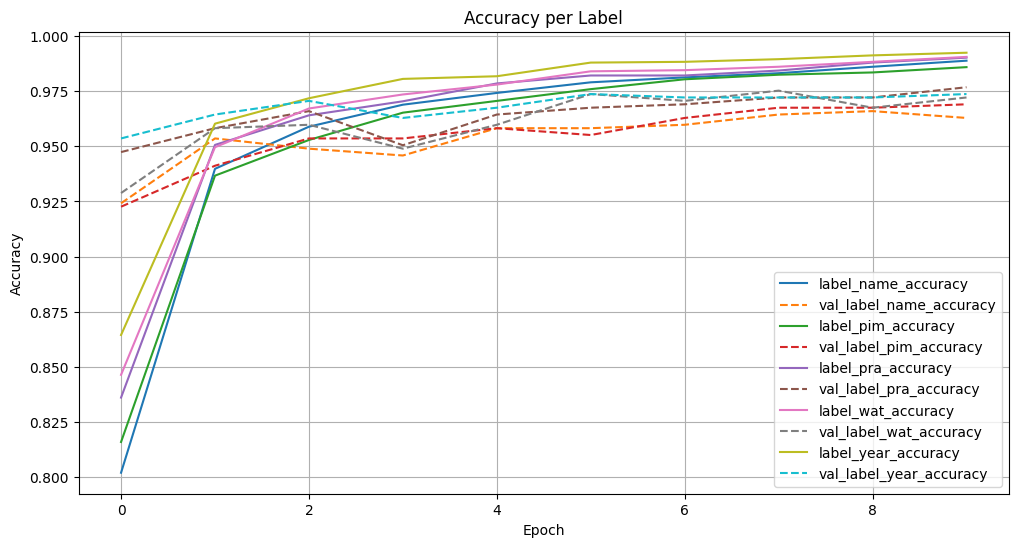

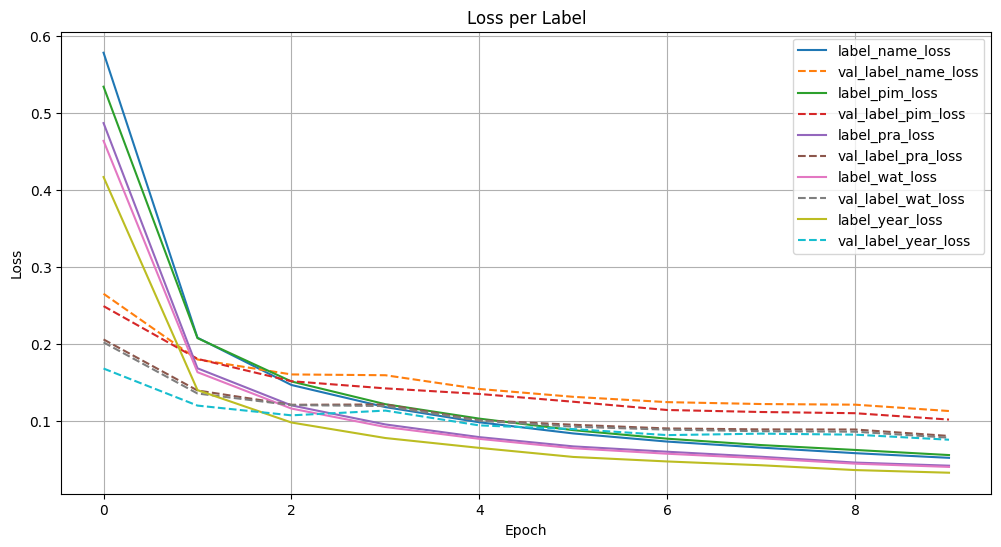

In [24]:

history_dict = history.history
metrics = ['label_name_accuracy', 'label_pim_accuracy', 'label_pra_accuracy', 'label_wat_accuracy', 'label_year_accuracy']
val_metrics = ['val_' + m for m in metrics]

losses = ['label_name_loss', 'label_pim_loss', 'label_pra_loss', 'label_wat_loss', 'label_year_loss']
val_losses = ['val_' + l for l in losses]

# พล็อต Accuracy
plt.figure(figsize=(12, 6))
for m, val_m in zip(metrics, val_metrics):
    plt.plot(history_dict[m], label=m)
    plt.plot(history_dict[val_m], linestyle='--', label=val_m)
plt.title('Accuracy per Label')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# พล็อต Loss
plt.figure(figsize=(12, 6))
for l, val_l in zip(losses, val_losses):
    plt.plot(history_dict[l], label=l)
    plt.plot(history_dict[val_l], linestyle='--', label=val_l)
plt.title('Loss per Label')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# พล็อตกราฟหลังใช้โมเดลอื่นมาเทรนต่อ


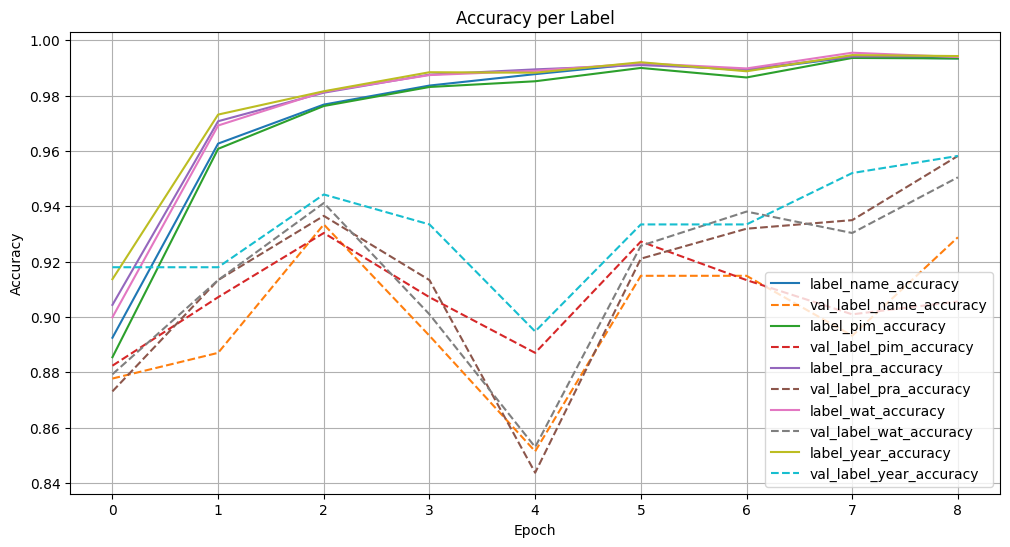

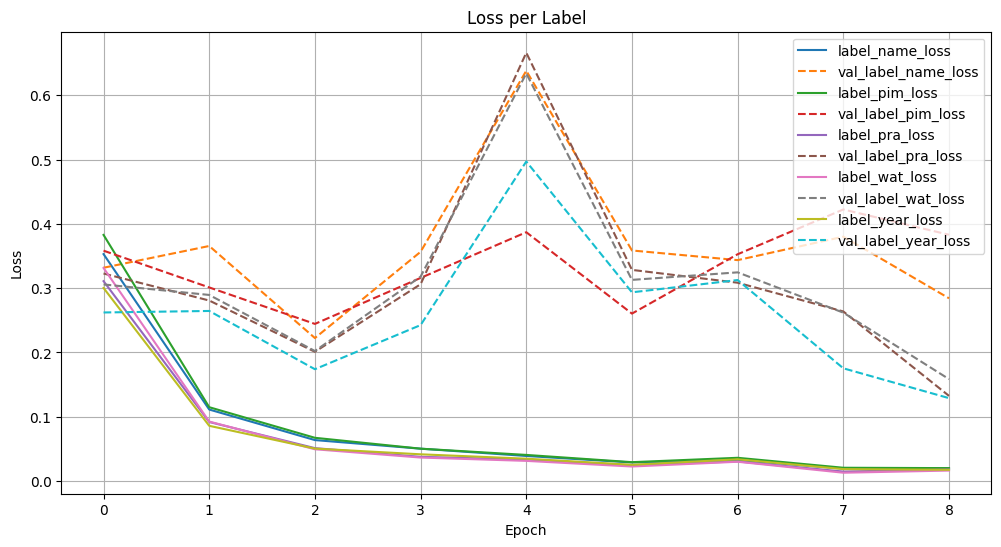

In [25]:
history_dict = history_fine.history
metrics = ['label_name_accuracy', 'label_pim_accuracy', 'label_pra_accuracy', 'label_wat_accuracy', 'label_year_accuracy']
val_metrics = ['val_' + m for m in metrics]

losses = ['label_name_loss', 'label_pim_loss', 'label_pra_loss', 'label_wat_loss', 'label_year_loss']
val_losses = ['val_' + l for l in losses]

# พล็อต Accuracy
plt.figure(figsize=(12, 6))
for m, val_m in zip(metrics, val_metrics):
    plt.plot(history_dict[m], label=m)
    plt.plot(history_dict[val_m], linestyle='--', label=val_m)
plt.title('Accuracy per Label')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# พล็อต Loss
plt.figure(figsize=(12, 6))
for l, val_l in zip(losses, val_losses):
    plt.plot(history_dict[l], label=l)
    plt.plot(history_dict[val_l], linestyle='--', label=val_l)
plt.title('Loss per Label')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# โหลดรูป test และทำการปรับรูปเพื่อไปวัดผลกับโมเดล

In [26]:
def load_image(filename):
    image = tf.keras.preprocessing.image.load_img(f"/content/fetsh_v2/images_test/{filename}", target_size=image_size)#โหลดภาพจากโฟลเดอร์และย่อขนาด
    image = tf.keras.preprocessing.image.img_to_array(image) # แปลงภาพเป็น (128, 128, 3)
    image = image / 255.0  # normalize เหมือนตอนเทรน 0,1
    return image

X_test = np.array([load_image(fname) for fname in df_test['filename']]) #ลูปชื่อไฟล์จากคอลัมfilename

# เตรียมค่าจริงของรูป test ให้โมเดลอ่านได้

In [27]:
# ตรวจ label ที่ไม่เคยเจอ
for col in encoders:
    unseen_labels = set(df_test[col].unique()) - set(encoders[col].classes_) # ดูว่ามีค่าlabelที่โมเดลไม่เคยเจอมั้ย
    if unseen_labels:
        print(f"⚠️ พบ label ที่ไม่เคยเจอในการเทรน: {col} -> {unseen_labels}")

# แปลงlabelsด้วยencoderเดิม
y_test = []

for col in encoders:
    encoded = encoders[col].transform(df_test[col])#ใช้ encoder เดิมแปลงข้อความเป็นตัวเลข 0 1 2
    one_hot = to_categorical(encoded, num_classes=len(encoders[col].classes_)) #แปลงค่าตัวเลขให้เป็น One-hot
    y_test.append(one_hot.astype('float32'))  # เปลี่ยน dtype เป็น float32


In [28]:
#ดูข้อมูลในโฟล์เดอร์ test
image_dir = '/content/fetsh_v2/images_test/'
all_files = os.listdir(image_dir)
image_files = [f for f in all_files if f.endswith('.png')]

print(f'จำนวนรูปภาพในโฟลเดอร์: {len(X_test)}')
print(f'จำนวนแถวใน df_test: {len(df_test)}')
print(f'จำนวนแถวไม่ซ้ำใน df_test[\'filename\']: {df_test["filename"].nunique()}')

จำนวนรูปภาพในโฟลเดอร์: 707
จำนวนแถวใน df_test: 707
จำนวนแถวไม่ซ้ำใน df_test['filename']: 707


# ประเมิณผล และดูค่า loss

In [29]:
#ประเมินผล
results = model.evaluate(X_test, y_test, verbose=1)

for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - label_name_accuracy: 0.9098 - label_name_loss: 0.2649 - label_pim_accuracy: 0.8913 - label_pim_loss: 0.3095 - label_pra_accuracy: 0.8922 - label_pra_loss: 0.2939 - label_wat_accuracy: 0.8984 - label_wat_loss: 0.2780 - label_year_accuracy: 0.7539 - label_year_loss: 1.6964 - loss: 2.8516
loss: 2.7289
compile_metrics: 0.3732
label_pra_loss: 0.3393
label_wat_loss: 0.3875
label_pim_loss: 1.2023
label_year_loss: 0.3195
label_name_loss: 0.8996


# ดูค่า accuracy

In [30]:
preds = model.predict(X_test) #ทำนายผลจาก X_test

for i, key in enumerate(['label_pra', 'label_wat', 'label_pim', 'label_year', 'name']):
    y_true = np.argmax(y_test[i], axis=1)
    y_pred = np.argmax(preds[i], axis=1)
    acc = np.mean(y_true == y_pred)

    print(f"{key} accuracy: {acc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step
label_pra accuracy: 0.8656
label_wat accuracy: 0.8755
label_pim accuracy: 0.8741
label_year accuracy: 0.7949
name accuracy: 0.8996


# ทำนายพระจากรูปจริง

In [31]:
def preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size, color_mode="rgb")
    img_array = image.img_to_array(img) / 255.0  # normalize
    return np.expand_dims(img_array, axis=0)  # เพิ่ม batch dimension

img_path = "/content/fetsh_v2/images_test/Test_306.png"  # เปลี่ยนเป็น path จริง
img_tensor = preprocess_image(img_path)

# ทำนาย
preds = model.predict(img_tensor)

predicted_labels = {}

for i, label_name in enumerate(encoders.keys()):
    pred_class = np.argmax(preds[i])  # หาคลาสที่น่าจะเป็นที่สุด
    class_name = encoders[label_name].classes_[pred_class]  # แปลงกลับเป็นชื่อ
    predicted_labels[label_name] = class_name

for label, value in predicted_labels.items():
    print(f"{label}: {value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
label_pra: พระกริ่งปวเรศ
label_wat: วัดบวรนิเวศวิหาร
label_pim: พิมพ์สมบูรณ์พูนสุข
label_year: 2434
name: สมเด็จพระมหาสมณเจ้า


# save model

In [ ]:
model.save('ResNet50.keras')

In [33]:
model_ConvNeXtTiny = tf.keras.models.load_model('ConvNeXtTiny.keras') #โหลดโมเดลที่เคย save ไว้
model_DenseNet121 = tf.keras.models.load_model('DenseNet121.keras')
model_ResNet50 = tf.keras.models.load_model('ResNet50.keras')
model_mobileNetV2 = tf.keras.models.load_model('MobileNetV2.keras')

models = { #
    'ConvNeXtTiny': model_ConvNeXtTiny,
    'DenseNet121': model_DenseNet121,
    'ResNet50': model_ResNet50,
    'MobileNetV2': model_mobileNetV2
}

output_names = ['label_pra', 'label_wat', 'label_pim', 'label_year', 'label_name']

for model_name, model in models.items():
    print(f"\n== Evaluating {model_name} ==")

    preds = model.predict(X_test, verbose=0)  # ✅ ได้ค่าทำนายของแต่ละ output

    for i, label in enumerate(output_names):
        y_true = np.argmax(y_test[i], axis=1)
        y_pred = np.argmax(preds[i], axis=1)
        acc = np.mean(y_true == y_pred)
        print(f"Accuracy {label}: {acc:.4f}")


== Evaluating ConvNeXtTiny ==
Accuracy label_pra: 0.8727
Accuracy label_wat: 0.8784
Accuracy label_pim: 0.8741
Accuracy label_year: 0.8006
Accuracy label_name: 0.8840

== Evaluating DenseNet121 ==
Accuracy label_pra: 0.9137
Accuracy label_wat: 0.9250
Accuracy label_pim: 0.9590
Accuracy label_year: 0.8289
Accuracy label_name: 0.9406

== Evaluating ResNet50 ==
Accuracy label_pra: 0.6747
Accuracy label_wat: 0.6761
Accuracy label_pim: 0.6209
Accuracy label_year: 0.6803
Accuracy label_name: 0.6294

== Evaluating MobileNetV2 ==
Accuracy label_pra: 0.8487
Accuracy label_wat: 0.8133
Accuracy label_pim: 0.8444
Accuracy label_year: 0.8175
Accuracy label_name: 0.8444
